# 1.Data Cleaning

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# import modules
import os
import json
import numpy as np
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, pearsonr, ttest_ind, spearmanr
from scipy.interpolate import interp1d, PchipInterpolator
from glob import glob
from datetime import datetime
from IPython.display import clear_output
import random

## 1.1Raw Data

In [3]:
def data_generation():
    PreDiag_parameters = 'Data/battery_cycling_data/PreDiag_parameters.csv'
    testParamDf = pd.read_csv(PreDiag_parameters)

    testParamDf['charging_protocol'] = testParamDf['charge_constant_current_1'].astype(str) + '_'+ testParamDf['charge_constant_current_2'].astype(str) + '_'+ testParamDf['charge_cutoff_voltage'].astype(str) +'_'+ testParamDf['charge_constant_voltage_time'].astype(str) 
    testParamDf['CC1_CC2'] = testParamDf['charge_constant_current_1'].astype(str) + '_'+ testParamDf['charge_constant_current_2'].astype(str)
    testParamDf['discharging_protocol'] = testParamDf['discharge_constant_current'].astype(str) +  '_'+ testParamDf['discharge_cutoff_voltage'].astype(str) 
    testParamDf['DOD'] = testParamDf['charge_cutoff_voltage'].astype(str) + '_' + testParamDf['discharge_cutoff_voltage'].astype(str)

    # testParamDf
    DODs = len(testParamDf['DOD'].unique())
    print(f'Unique DODs {DODs}')
    discharge_protocols = len(testParamDf['discharging_protocol'].unique())
    print(f'Unique discharging_protocol {discharge_protocols}')
    charge_protocols = len(testParamDf['charging_protocol'].unique())
    print(f'Unique charging_protocol {charge_protocols}')

    print(len(testParamDf['discharge_cutoff_voltage'].unique()))
    print(len(testParamDf['CC1_CC2'].unique()))
    print(len(testParamDf['discharge_constant_current'].unique()))

    # (0) top left - RPT-calculated Capacities
    rpt_metrics_df_BVV_10_06_2021_TOTAL = 'Data/battery_cycling_data/rpt_metrics_df_BVV_10_06_2021_TOTAL.csv'

    RPT_metrics_df = pd.read_csv(rpt_metrics_df_BVV_10_06_2021_TOTAL).drop('Unnamed: 0',axis=1)
    RPT_metrics_df['cycle_index'] = RPT_metrics_df['diag_cycle_index_reset']+2

    # (1) top right - Resistances at 3 different SOCs
    ResistanceCombined = 'Data/battery_cycling_data/ResistanceCombined.csv'
    hppc_res_df = pd.read_csv(ResistanceCombined).set_index(['cycle_index'])
    hppc_res_df['r_tot_c_0'] = hppc_res_df['r_tot_c_0']*1000
    hppc_res_df['r_tot_c_5'] = hppc_res_df['r_tot_c_5']*1000
    hppc_res_df['r_tot_c_8'] = hppc_res_df['r_tot_c_8']*1000

    all_metrics_df = pd.merge(hppc_res_df, RPT_metrics_df,  how='left', left_on=['seq_num','cycle_index'], right_on = ['seq_num','cycle_index'])
    return all_metrics_df,testParamDf

In [76]:
def objective(x, a, b, c):
        return a * x * x + b * x + c
def raw_input():
    import math
    from numpy import arange
    from scipy.optimize import curve_fit
    Y={}

    from sklearn import preprocessing
    from sklearn.preprocessing import StandardScaler


    # for loop to fit capacity curve for all cells
    for i in range(328):
        for_one_cell = all_metrics_df.loc[(all_metrics_df.seq_num == list(all_metrics_df.seq_num.unique())[i])] # get all cycling data for 1 cell
        if len(for_one_cell) > 3:  # not select cells have too less data point
            y = for_one_cell['diag_discharge_capacity_rpt_0.2C']
            #x = for_one_cell['cycle_index']
            x = for_one_cell['equivalent_full_cycles']
            #y1 =  y / float(y.head(1)) 
            #X = flat(scaler_A.transform([[b] for b in x]))
            r_dis_oh = for_one_cell['r_d_o_0']
            r_dis_ct = for_one_cell['r_d_ct_0']
            r_dis_pul = for_one_cell['r_d_p_0']
            r_tot = r_dis_oh + r_dis_ct + r_dis_pul
            
            try:                           
                popt, _ = curve_fit(objective, x, y, bounds=([-1e-4,-0.002,4],[5e-5,0.02,5]))  # fit curve
            except:
                continue   # if not fit, continue to next cell
            else:
                a, b, c= popt
                k = for_one_cell.cycle_index.keys()[0]   
                key = all_metrics_df.seq_num[k]       # find seq_num of this cell
                y_pre = np.array([objective(x2, a, b,c) for x2 in x])  #calculate y_pre based on fiiting function
                rms = np.sqrt(np.sum(np.square((y_pre - y))) / len(y)) * 100 * len(y) / np.sum(y)  # calculate %RMS
                if rms < 5:   # select fittings within 5% RMS
                    Y[key] = [popt,rms,float(y.head(1)),float(r_tot.iloc[1])]  #store fitting params, %rms, initial capacity and resistance
    # create pd for Y matrix
    seq_num = pd.Series(Y.keys())
    cur_param = pd.Series(Y.values())
    cur_param_1 = pd.Series([cur[0][0] for cur in cur_param])
    cur_param_2 = pd.Series([cur[0][1] for cur in cur_param])
    cur_param_3 = pd.Series([cur[0][2] for cur in cur_param])
    cur_err = pd.Series([cur[1] for cur in cur_param])
    capacity_initial = pd.Series([cur[2] for cur in cur_param])
    resistance_initial = pd.Series([cur[3] for cur in cur_param])
    Y_matrix_pre = pd.DataFrame({'seq_num': seq_num, 'cur_param_1': cur_param_1, 'cur_param_2': cur_param_2, 'cur_param_3': cur_param_3,
                                'cur_err':cur_err, 'capacity_initial':capacity_initial, 'resistance_initial':resistance_initial})
    display(Y_matrix_pre)
    # prepare X matrix
    X_column_list = list(testParamDf.columns)[3:11]
    X_matrix = testParamDf[['seq_num'] + X_column_list]
    # merge X and Y matrix based on seq_num
    X_Y_merged = pd.merge(Y_matrix_pre, X_matrix,  how='left', left_on=['seq_num'], right_on = ['seq_num'])
    X_Y_merged = X_Y_merged.dropna()
    # normalize input X 
    scaler=preprocessing.StandardScaler().fit(X_Y_merged[['capacity_initial']+['resistance_initial']+X_column_list])
    X = scaler.transform(X_Y_merged[['capacity_initial']+['resistance_initial']+X_column_list])
    #display(X)
    y_matrix = [y[0] for y in Y.values()] 
    y = np.array(y_matrix)
    return X,y,Y,X_Y_merged

In [5]:
all_metrics_df,testParamDf = data_generation()

Unique DODs 18
Unique discharging_protocol 23
Unique charging_protocol 47
8
12
5


In [6]:
X,y,Y,X_Y_merged = raw_input()

,seq_num,cur_param_1,cur_param_2,cur_param_3,cur_err,capacity_initial,resistance_initial
0,124,-4.268516e-05,-0.001290,4.658009,0.569489,4.675529,0.042770
1,136,-7.541591e-07,-0.002000,4.438276,3.168251,4.653198,0.038496
2,137,-2.086180e-05,-0.002000,4.629700,1.547984,4.678366,0.039428
3,138,-2.131589e-05,-0.001060,4.654006,1.334329,4.677594,0.039335
4,141,-8.169265e-05,0.007191,4.568627,3.872434,4.666743,0.037988
...,...,...,...,...,...,...,...
285,481,-1.600062e-06,-0.001454,4.686074,0.120857,4.694725,0.037519
286,482,4.505926e-06,-0.001736,4.661689,0.142532,4.668373,0.038372
287,483,2.469732e-06,-0.001516,4.666438,0.161406,4.675742,0.038067
288,484,2.164609e-06,-0.001429,4.632704,0.155989,4.641778,0.038118


## 1.2 Data Aug

### Regular X and Y

In [9]:
#X_log = np.log(X)
#X_sqrt_root = np.power(X,2)

In [10]:
#key_parameters
y_matrix_key = np.array([k for k,y in Y.items()]).reshape(-1,1)
y_selected_key = y_matrix_key.squeeze()
#y with key column
y_with_key = np.append(y, y_matrix_key, axis = 1)

## 1.3 Y visualization -> Linear Scaling

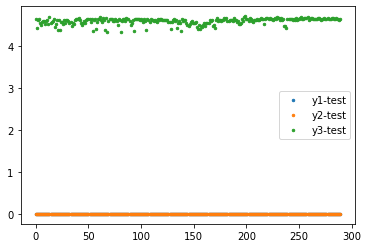

In [11]:
x_ax = range(len(X))
plt.scatter(x_ax, y[:,0],  s=6, label="y1-test")
plt.scatter(x_ax, y[:,1],  s=6, label="y2-test")
plt.scatter(x_ax, y[:,2],  s=6, label="y3-test")
plt.legend()
plt.show()

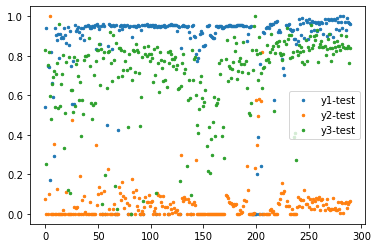

In [12]:
x_ax = range(len(X))
plt.scatter(x_ax, (y[:,0]-min(y[:,0]))/(max(y[:,0])-min(y[:,0])),  s=6, label="y1-test")
plt.scatter(x_ax, (y[:,1]-min(y[:,1]))/(max(y[:,1])-min(y[:,1])),  s=6, label="y2-test")
plt.scatter(x_ax, (y[:,2]-min(y[:,2]))/(max(y[:,2])-min(y[:,2])),  s=6, label="y3-test")
plt.legend()
plt.show()

In [105]:
def plot_empirical(l,d):
    for i in range(328):
        for_one_cell = all_metrics_df.loc[(all_metrics_df.seq_num == list(all_metrics_df.seq_num.unique())[i])] # get all cycling data for 1 cell
        if len(for_one_cell) > 3:  # not select cells have too less data point
            y = for_one_cell['diag_discharge_capacity_rpt_0.2C']
            #x = for_one_cell['cycle_index']
            x = for_one_cell['equivalent_full_cycles']
            #y1 =  y / float(y.head(1)) 
            r_dis_oh = for_one_cell['r_d_o_0']
            r_dis_ct = for_one_cell['r_d_ct_0']
            r_dis_pul = for_one_cell['r_d_p_0']
            r_tot = r_dis_oh + r_dis_ct + r_dis_pul
            plt.plot(x,y)
            plt.xlabel("Equivalent Full Cycle")
            plt.ylabel("Capacity")
            plt.title("Capacity degradation",fontsize=16)
            plt.xlim(0,l)
            plt.ylim(d,5)
def plot_empirical_selected(key,l,d):
    for i in key:
        for_one_cell = all_metrics_df.loc[(all_metrics_df.seq_num == i)] # get all cycling data for 1 cell
        if len(for_one_cell) > 3:  # not select cells have too less data point
            y = for_one_cell['diag_discharge_capacity_rpt_0.2C']
            #x = for_one_cell['cycle_index']
            x = for_one_cell['equivalent_full_cycles']
            #y1 =  y / float(y.head(1)) 
            r_dis_oh = for_one_cell['r_d_o_0']
            r_dis_ct = for_one_cell['r_d_ct_0']
            r_dis_pul = for_one_cell['r_d_p_0']
            r_tot = r_dis_oh + r_dis_ct + r_dis_pul
            plt.plot(x,y)
            plt.xlabel("Equivalent Full Cycle")
            plt.ylabel("Capacity")
            plt.title("Capacity degradation",fontsize=16)
            plt.xlim(0,l)
            plt.ylim(d,5)
#predicted gamma
def plot_curve_pred(y,key,l,d):
    itera = len(y)
    for i in key:
        cell_num = i
        for_one_cell = all_metrics_df.loc[(all_metrics_df.seq_num == cell_num)]

        #extract the cycle number
        x_range = np.floor(for_one_cell['equivalent_full_cycles'].max())
        x = np.arange(x_range)

        #predicted capacity
        selected = y[:,3] == cell_num
        a_t1,b_t1,c_t1 = y[selected,0:3][0]

        acapacity_test_1 = objective(x,a_t1,b_t1,c_t1)
        plt.plot(x,acapacity_test_1,label = '{}'.format(i))
        
    plt.xlabel("Equivalent Full Cycle")
    plt.ylabel("Capacity")
    plt.title("Capacity degradation",fontsize=16)
    if len(key)<2:
        plt.legend()
    plt.xlim(0,l)
    plt.ylim(d,5)

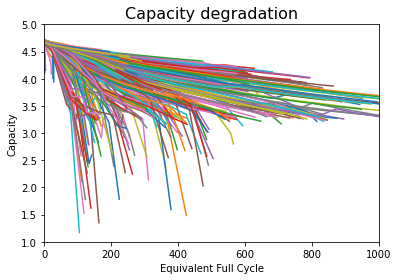

In [78]:
l=1000
d=1
plot_empirical(l,d)

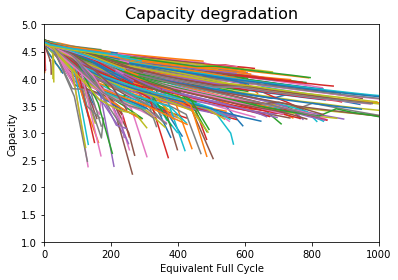

In [79]:
plot_empirical_selected(y_selected_key,l,d)

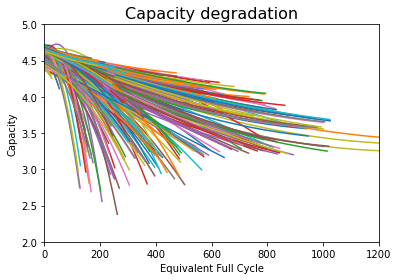

In [106]:
plot_curve_pred(y_with_key,y_selected_key,l,d)

## 1.4 Correlation Map

In [66]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator,HillClimbSearch
from pgmpy.estimators.StructureScore import K2Score, BDeuScore, BDsScore, BicScore
#!pip install seaborn

In [ ]:
Y_column_list = ['cur_param_1','cur_param_2','cur_param_3']	
bBayesian_test = X_Y_merged[['capacity_initial']+['resistance_initial']+X_column_list+Y_column_list]
Bayesian_test.to_csv('Beyesian_battery.csv')

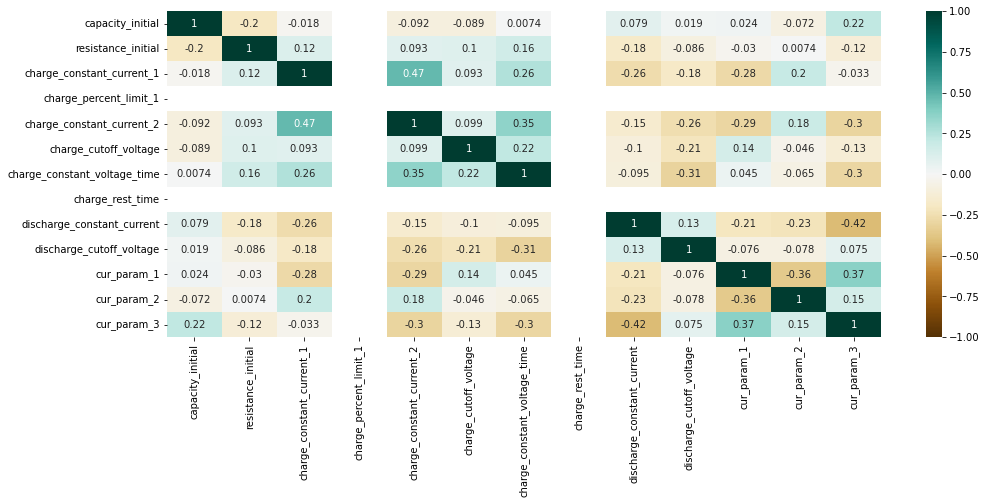

In [71]:
Bayesian_test = pd.read_csv('Beyesian_battery.csv',index_col=0)
corrMatrix = Bayesian_test.corr()
plt.figure(figsize=(16,6))
sn.heatmap(corrMatrix, vmin=-1, vmax=1, annot=True,cmap='BrBG')
plt.show()

# 2. Train the model

In [21]:
def norm (x,x_train):
    return (x-x_train.min(axis=0))/(x_train.max(axis=0)-x_train.min(axis=0))
def recover(x,x_train):
    return x*(x_train.max(axis=0)-x_train.min(axis=0))+x_train.min(axis=0)
def train_model(X,y_with_key,model):
    X_copy = X.copy()
    y_with_key_copy = y_with_key.copy()
    X_train, X_test, y_train_coef, y_test_coef = train_test_split(X_copy, y_with_key_copy, test_size=0.2, random_state=3)
    y_train = y_train_coef[:,0:3]
    y_test = y_test_coef[:,0:3]

    y_train_norm = norm(y_train,y_train)
    y_test_norm =  norm(y_test,y_train)


def sequential_model(l1,l2,loss_method,in_dim= X_train.shape[1],out_dim= y_train.shape[1]):
    model0 = Sequential([
    Dense(l1, input_dim=in_dim, activation="relu"),
    Dense(l2, activation="relu"),
    Dense(out_dim)
    ])
    model0.compile(loss=loss_method,
                    optimizer="adam",
                    metrics = ['accuracy'])
    return model0


In [28]:
def data_split(X,y_with_key,i=3):
    X_copy = X.copy()
    y_with_key_copy = y_with_key.copy()
    X_train, X_test, y_train_coef, y_test_coef = train_test_split(X_copy, y_with_key_copy, test_size=0.2, random_state=3)
    y_train = y_train_coef[:,0:i]
    y_test = y_test_coef[:,0:i]

    y_train_norm = norm(y_train,y_train)
    y_test_norm =  norm(y_test,y_train)
    return X_train,X_test,y_train_coef,y_test_coef,y_train,y_test,y_train_norm,y_test_norm

In [36]:
#full gamma
X_train,X_test,y_train_coef,y_test_coef,y_train,y_test,y_train_norm,y_test_norm=data_split(X,y_with_key)
#gamma 1 only
X_train1,X_test1,y_train_coef1,y_test_coef1,y_train1,y_test1,y_train_norm1,y_test_norm1=data_split(X,y_with_key,1)

In [89]:
#mae
model0 = sequential_model(50,32,'mae')
model0.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 99        
Total params: 2,281
Trainable params: 2,281
Non-trainable params: 0
_________________________________________________________________


# 3.Prediction

In [90]:
#no validation
lr_model_history_no_val = model0.fit(X_train, y_train_norm, 
                        epochs=100, 
                        verbose=0)

raw_y_pred = model0.predict(X_test)
y_pred = recover(raw_y_pred,y_train)
print("y1 MSE:%.4f" % mean_squared_error(y_test[:,0], y_pred[:,0]))
print("y2 MSE:%.4f" % mean_squared_error(y_test[:,1], y_pred[:,1]))
print("y2 MSE:%.4f" % mean_squared_error(y_test[:,2], y_pred[:,2]))

2021-11-05 05:14:02.605680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


y1 MSE:0.0000
y2 MSE:0.0000
y2 MSE:0.0037


2021-11-05 05:14:06.537305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


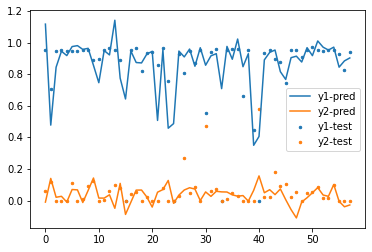

In [91]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test_norm[:,0],  s=6, label="y1-test")
plt.plot(x_ax, raw_y_pred[:,0], label="y1-pred")
plt.scatter(x_ax, y_test_norm[:,1],  s=6, label="y2-test")
plt.plot(x_ax, raw_y_pred[:,1], label="y2-pred")
plt.legend()
plt.show()

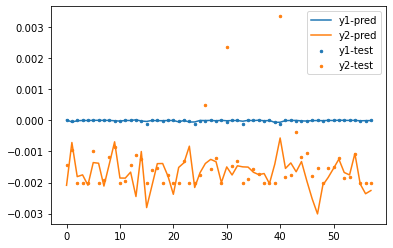

In [92]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test[:,0],  s=6, label="y1-test")
plt.plot(x_ax, y_pred[:,0], label="y1-pred")
plt.scatter(x_ax, y_test[:,1],  s=6, label="y2-test")
plt.plot(x_ax, y_pred[:,1], label="y2-pred")
plt.legend()
plt.show()

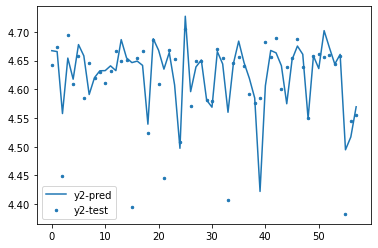

In [93]:
plt.scatter(x_ax, y_test[:,2],  s=6, label="y2-test")
plt.plot(x_ax, y_pred[:,2], label="y2-pred")
plt.legend()
plt.show()

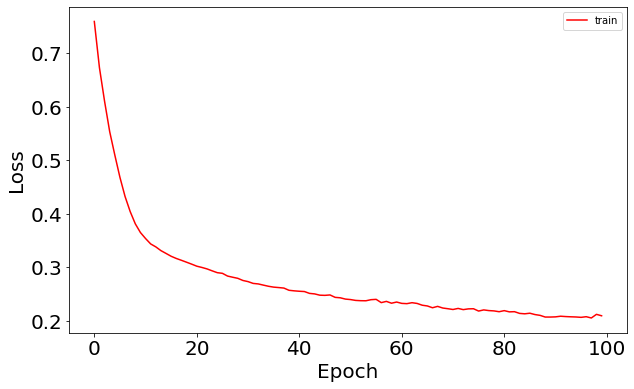

In [94]:

# Plot the loss function with no val
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history_no_val.history['loss']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

## What if we add validation part?

2021-11-05 05:12:15.982120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 05:12:16.093382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 05:12:20.599891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


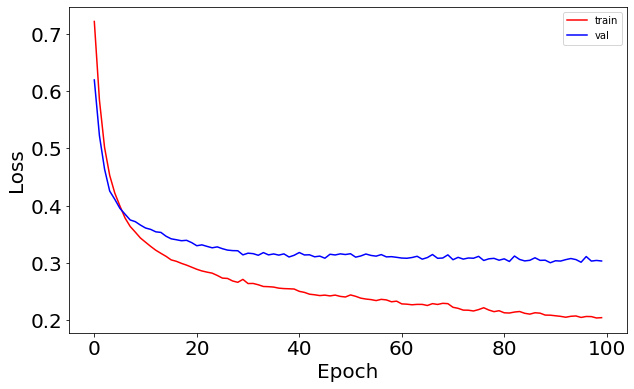

In [68]:
# Plot the loss function
lr_model_history = model0.fit(X_train, y_train_norm, 
                            epochs=100, 
                            verbose=0,
                            validation_data=(X_test, y_test_norm))

y_pred = model0.predict(X_test)*y_train.max(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [95]:
test_key = y_test_coef[:,3]
l = 1200
d = 2

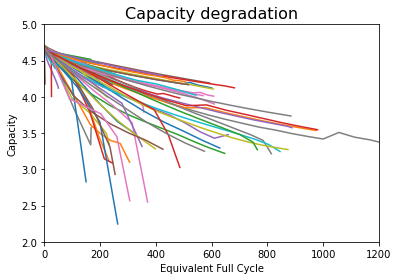

In [96]:
plot_empirical_selected(test_key,l,d)

In [97]:
y_pred.shape,test_key.shape

((58, 3), (58,))

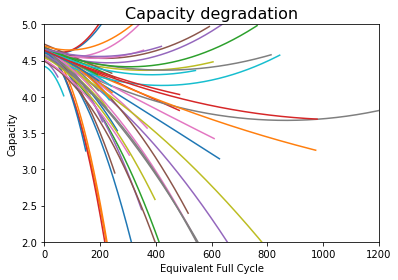

In [98]:
y_with_key_test = np.append(y_pred, test_key.reshape(-1,1), axis = 1)
plot_curve_pred(y_with_key_test,test_key,l,d)

/var/folders/_w/m21mbpwj00q_0ghj07dwvwj80000gn/T/ipykernel_1388/1579066949.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(key)


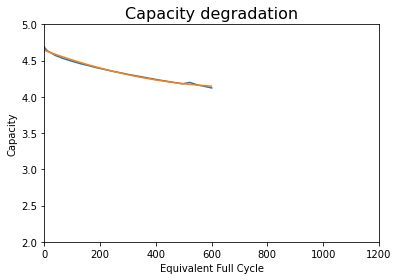

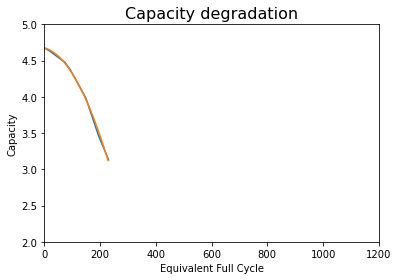

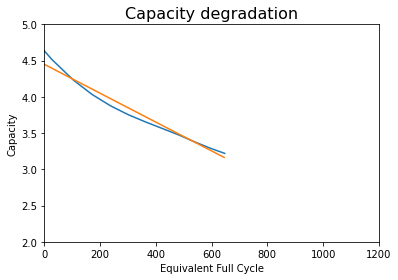

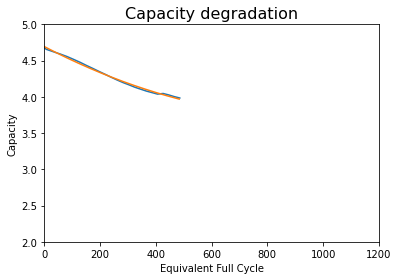

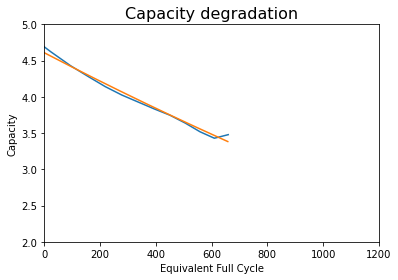

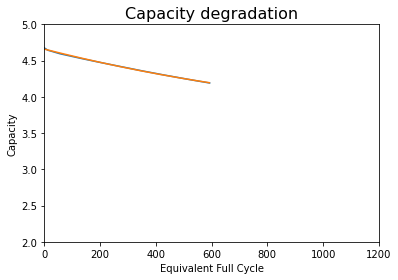

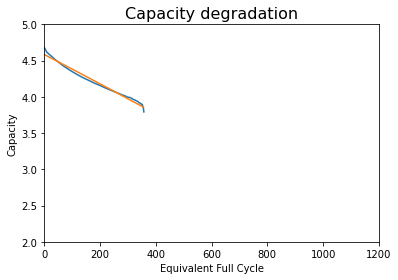

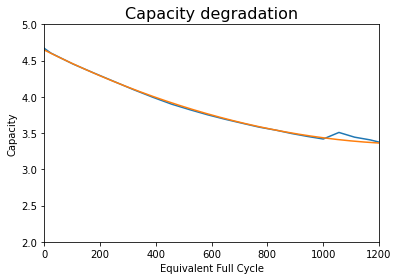

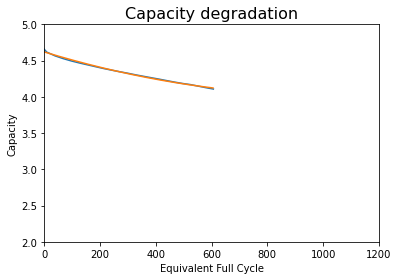

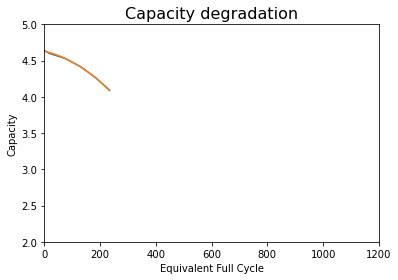

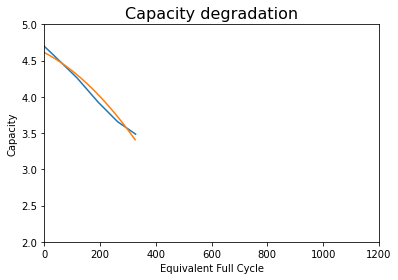

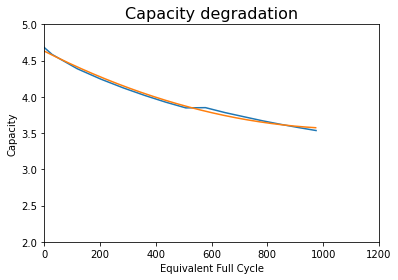

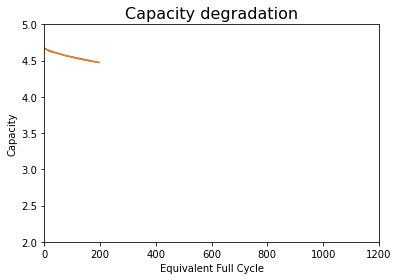

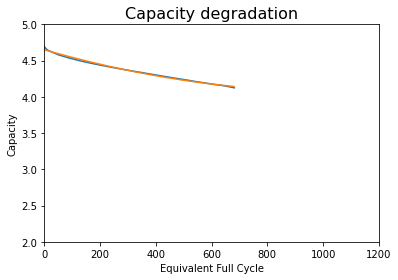

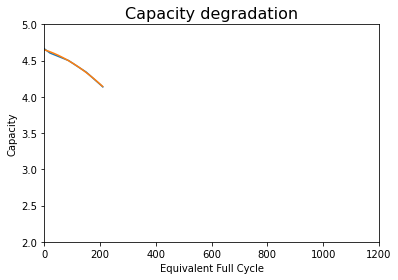

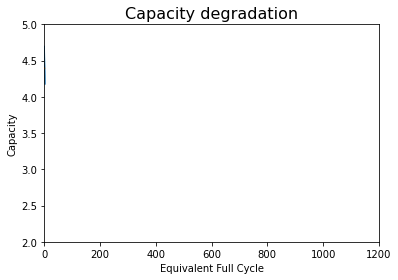

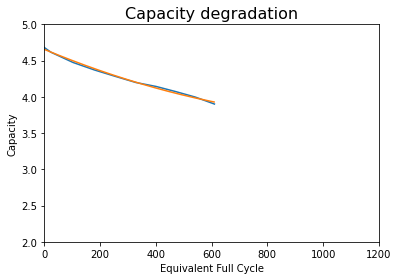

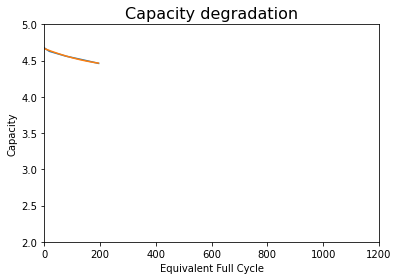

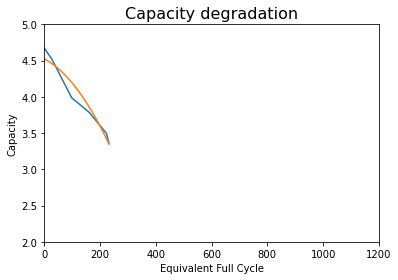

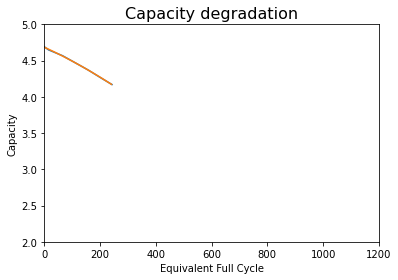

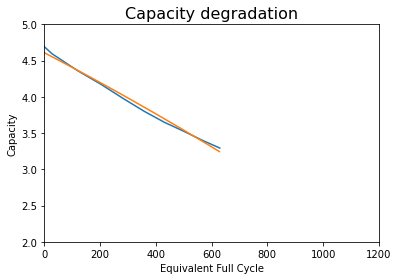

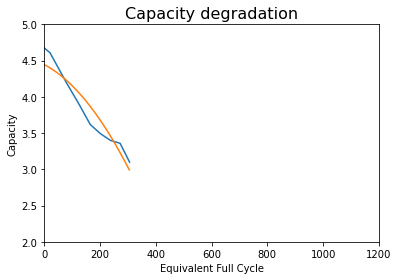

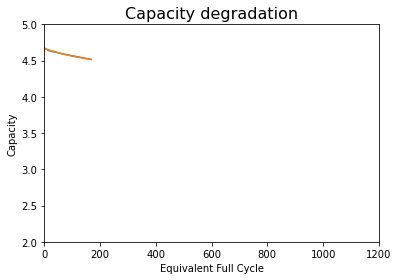

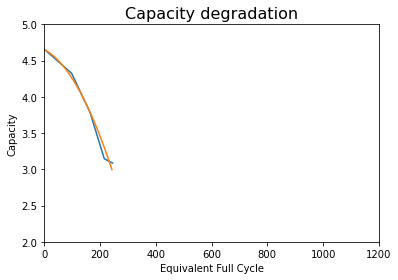

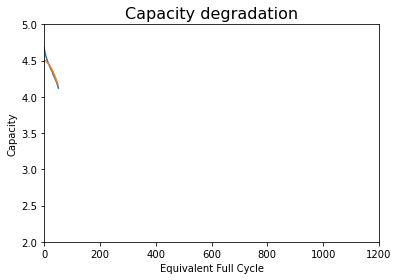

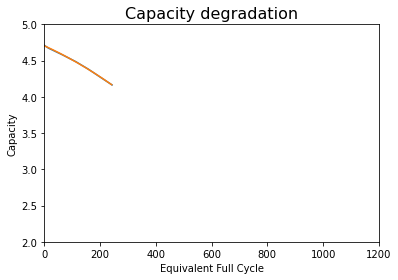

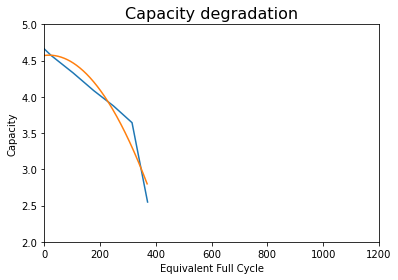

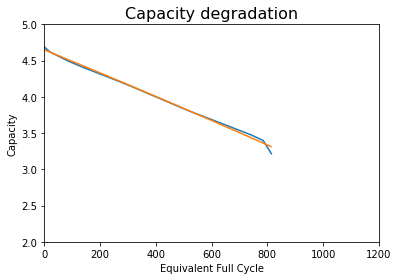

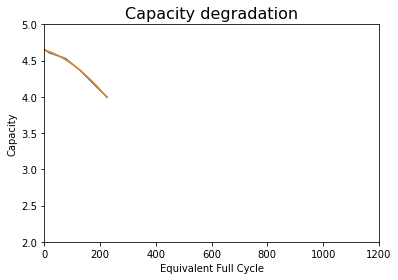

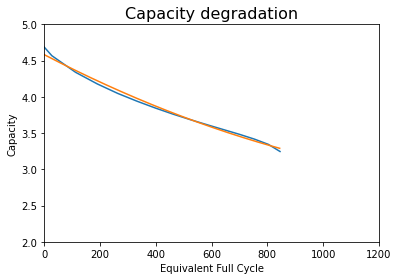

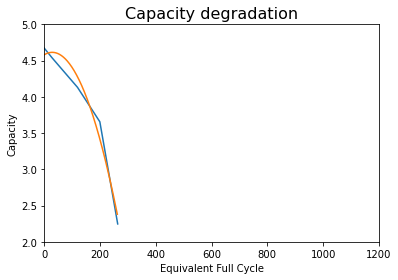

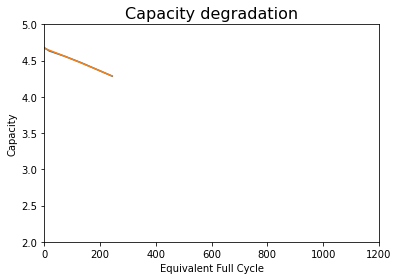

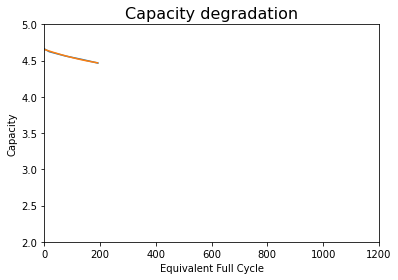

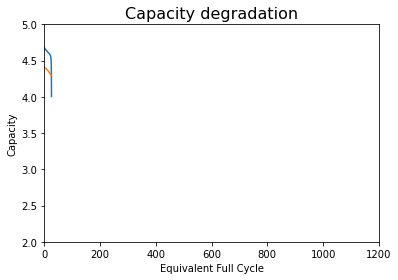

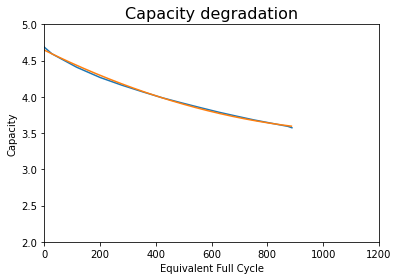

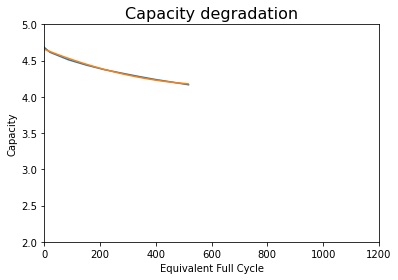

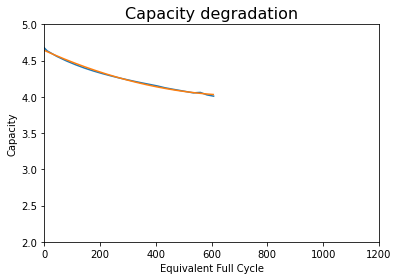

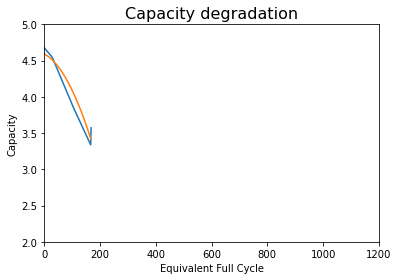

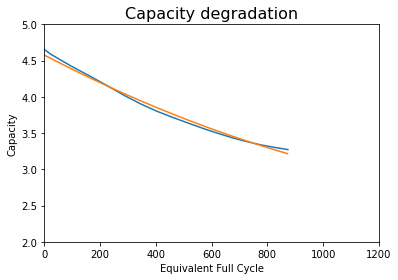

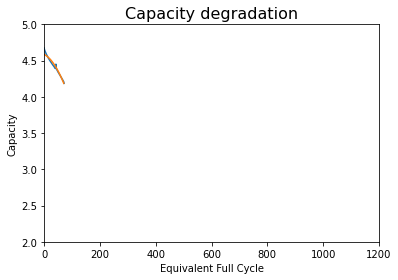

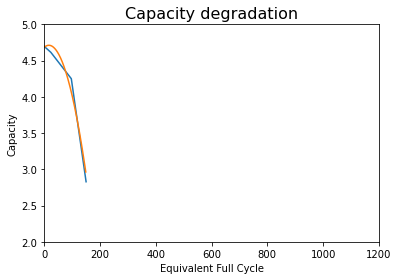

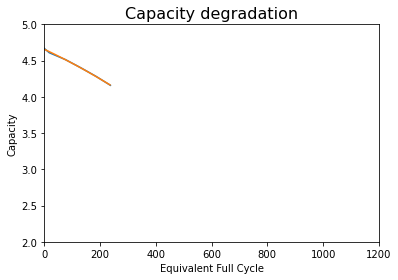

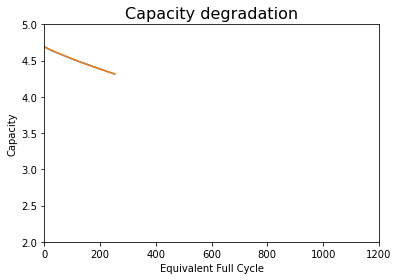

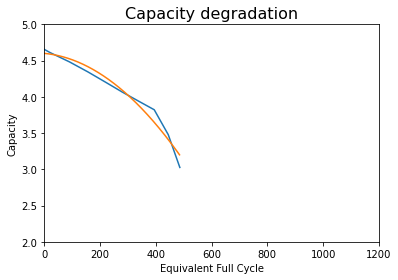

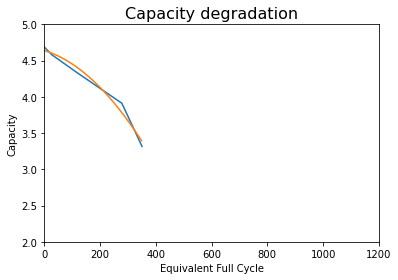

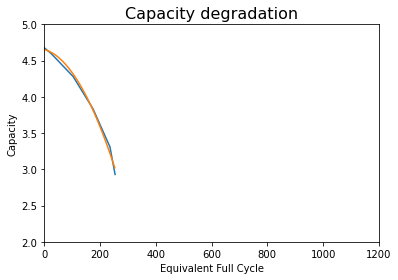

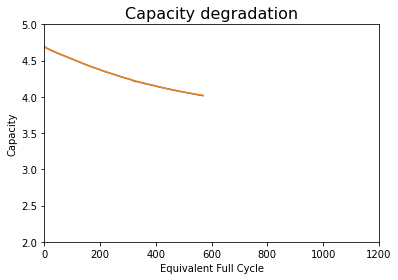

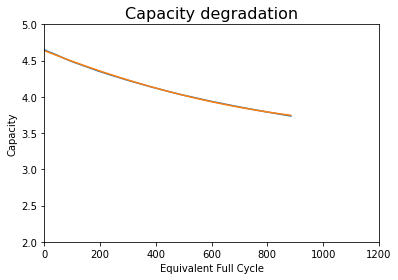

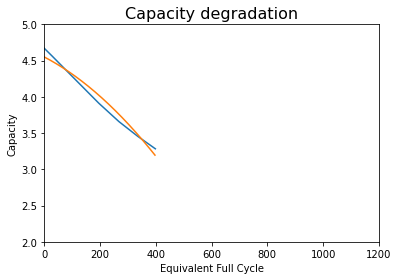

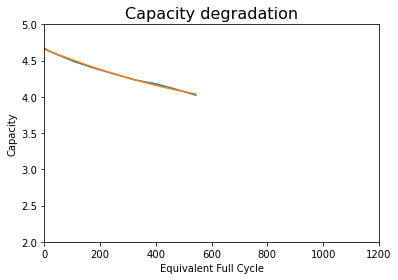

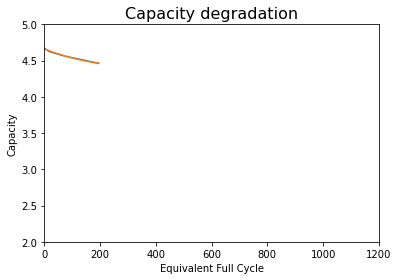

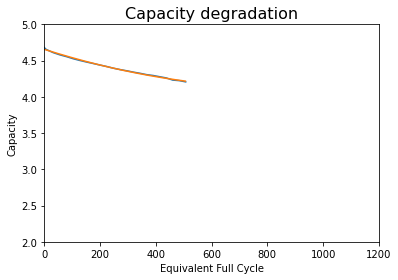

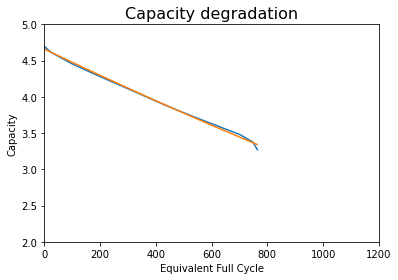

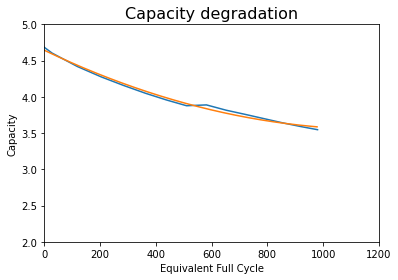

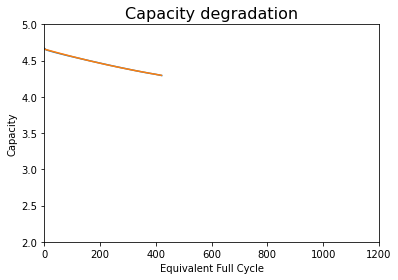

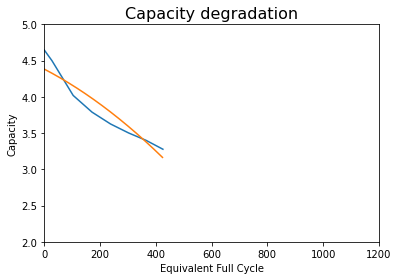

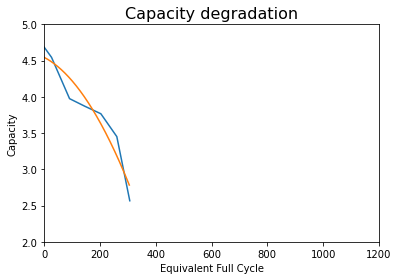

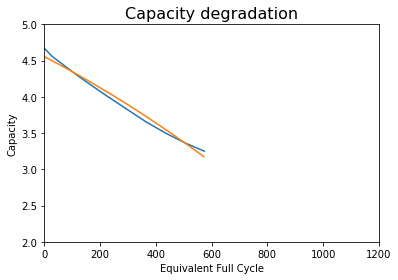

In [99]:
#true curve
for key in test_key:
    inputk = np.array([key])
    plt.figure(key)
    plot_empirical_selected(inputk,l,d)
    plot_curve_pred(y_with_key,inputk,l,d)


In [110]:
n=184
select_cell = y_with_key[:,3] == n
print(y_with_key[select_cell,:])
select_cell = y_with_key_test[:,3] == n
print(y_with_key_test[select_cell,:])

[[ 7.07886379e-07 -1.91881827e-03  4.64608047e+00  1.84000000e+02]]
[[ 1.22061542e-06 -2.11443536e-03  4.59102177e+00  1.84000000e+02]]


/var/folders/_w/m21mbpwj00q_0ghj07dwvwj80000gn/T/ipykernel_1388/4097272028.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(key)


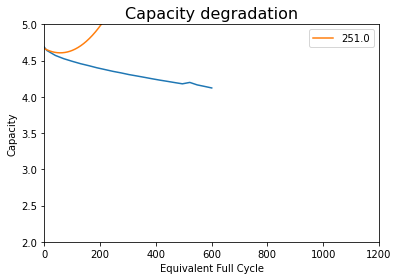

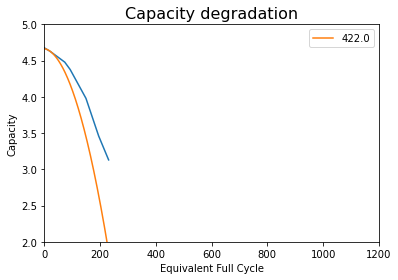

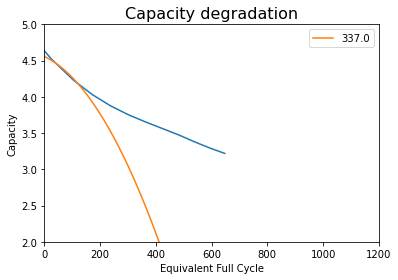

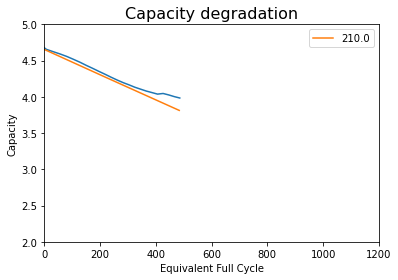

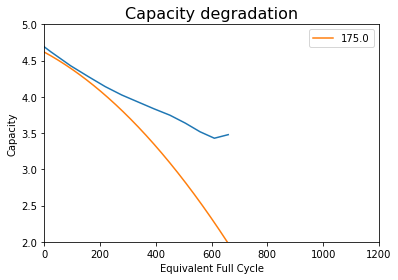

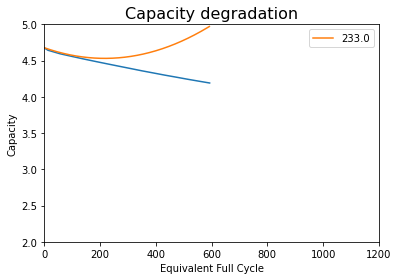

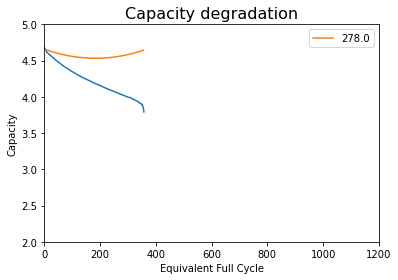

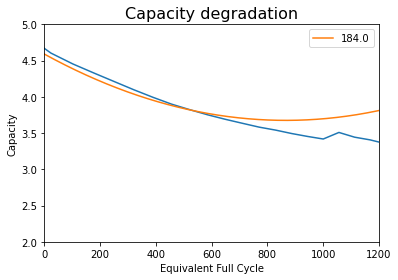

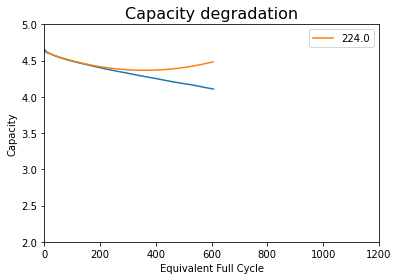

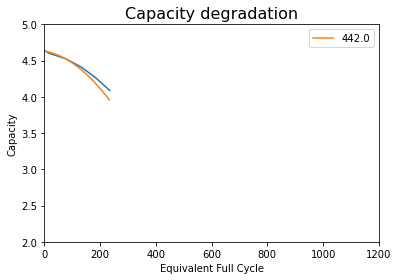

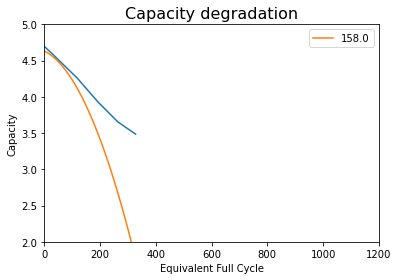

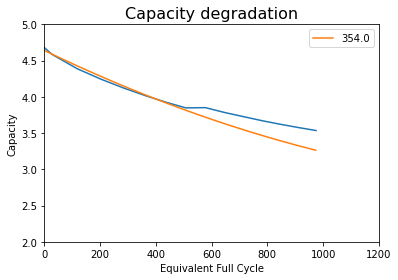

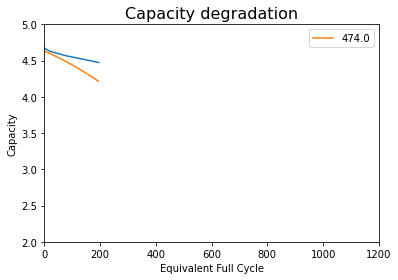

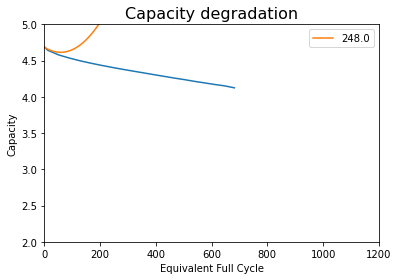

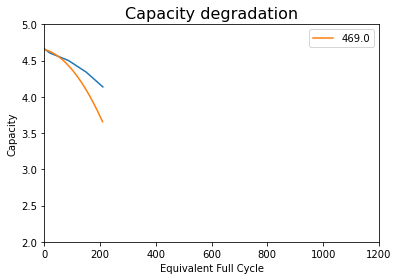

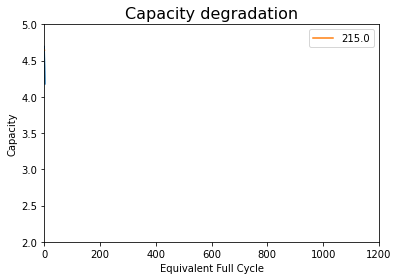

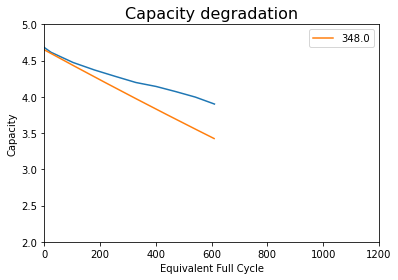

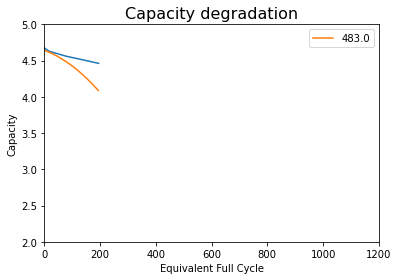

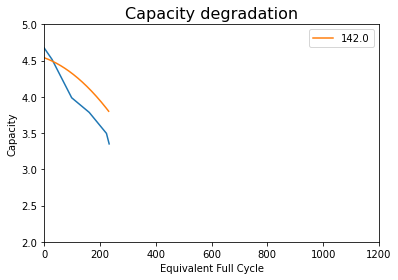

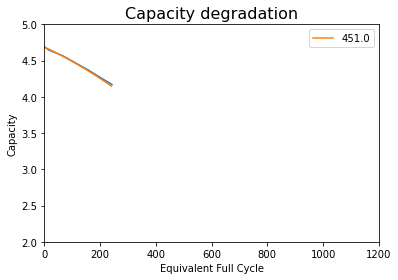

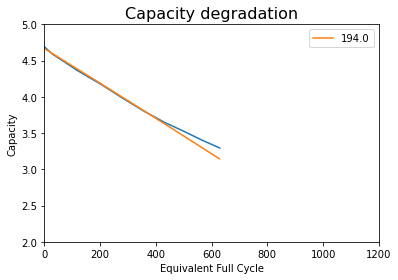

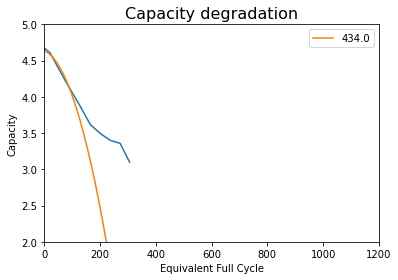

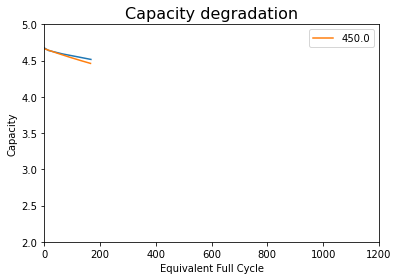

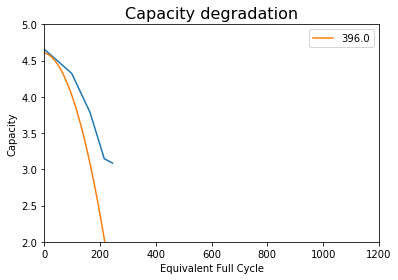

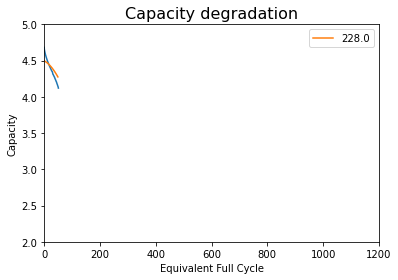

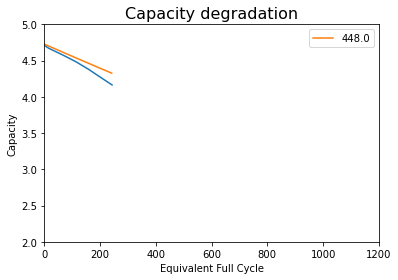

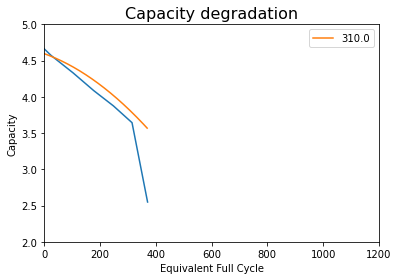

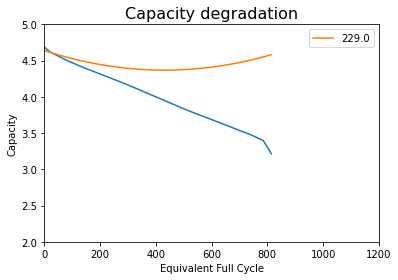

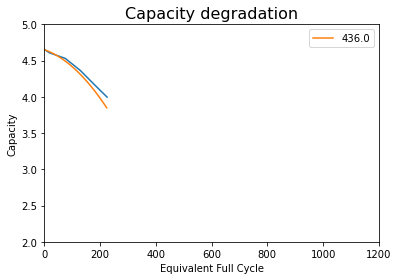

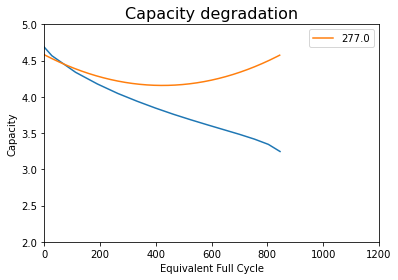

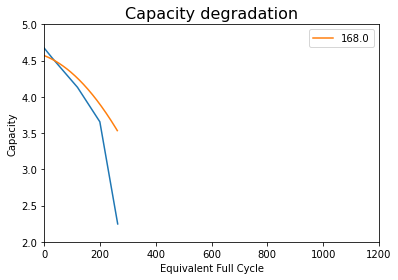

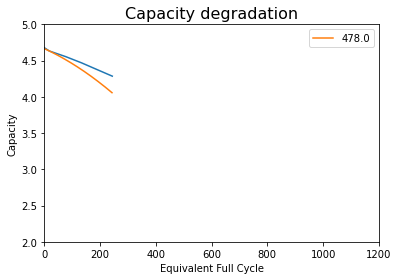

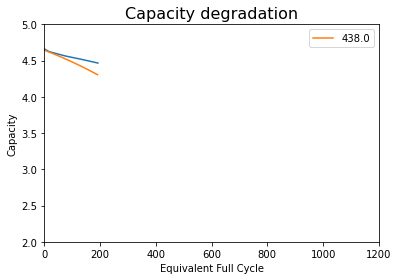

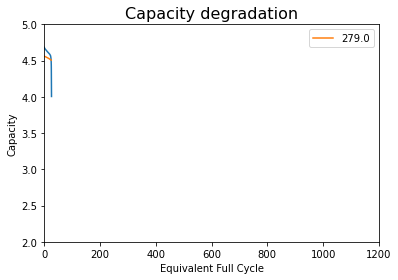

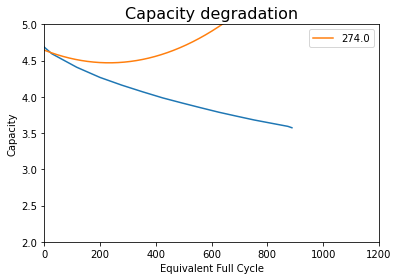

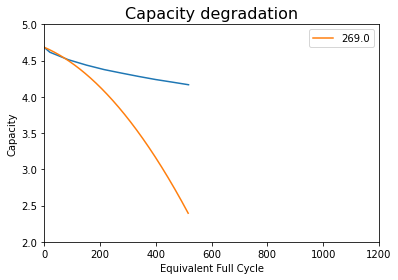

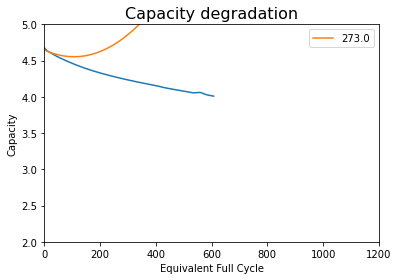

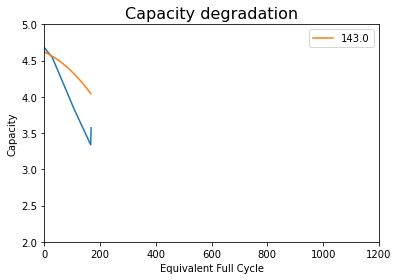

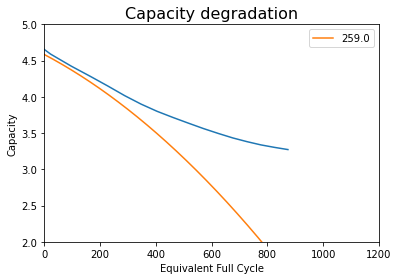

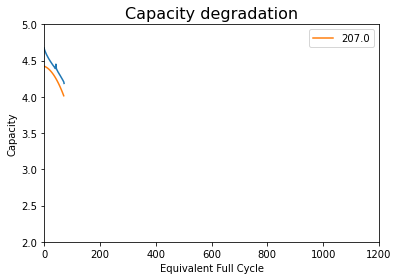

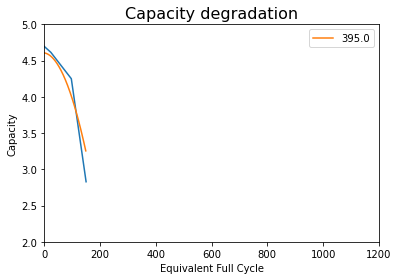

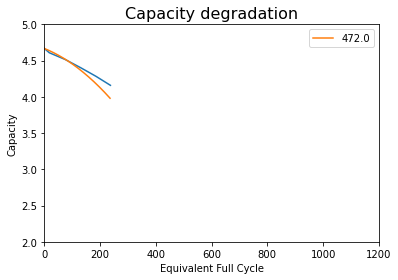

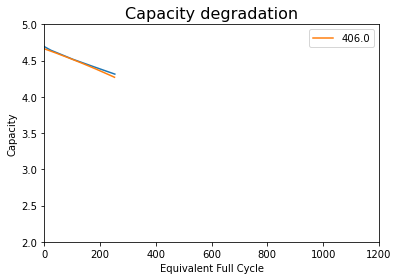

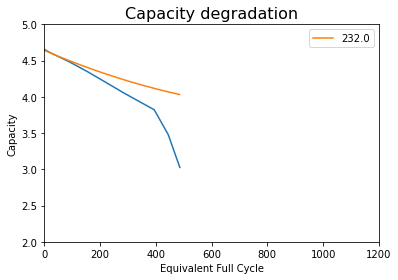

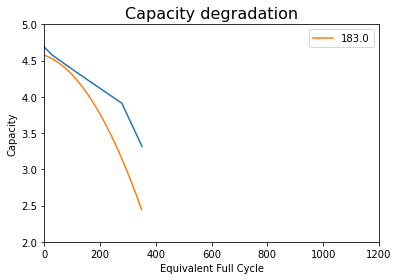

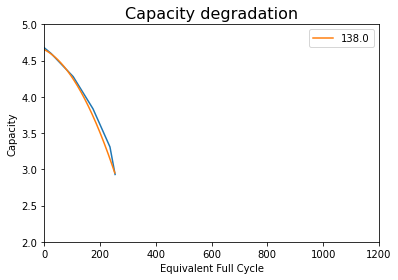

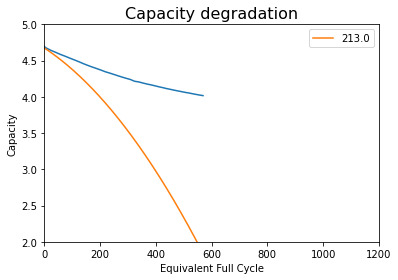

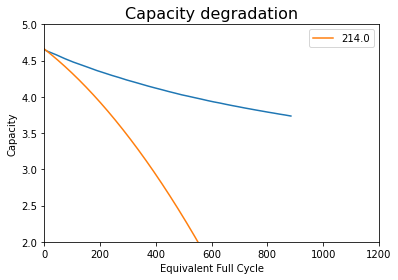

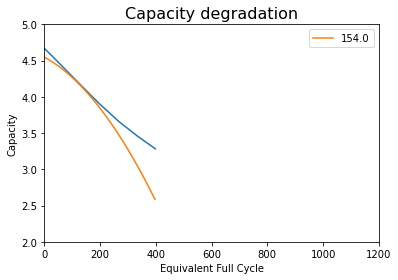

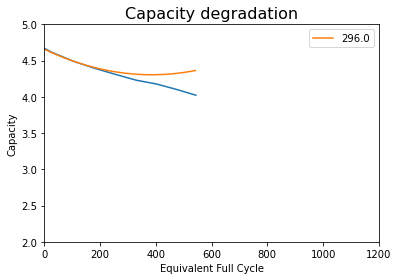

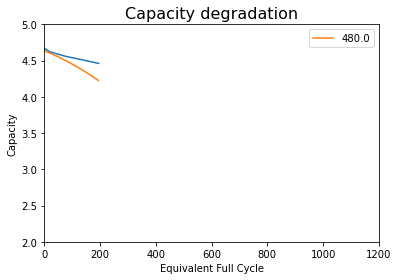

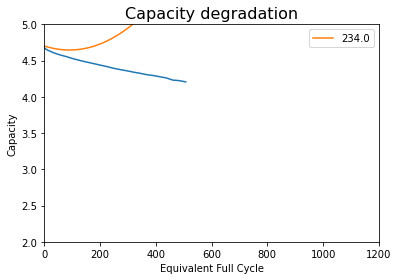

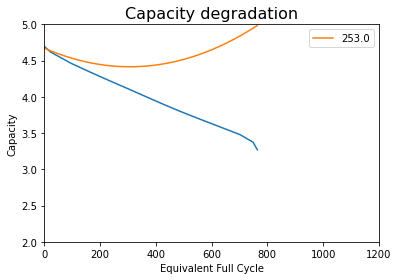

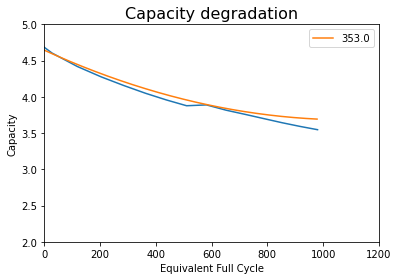

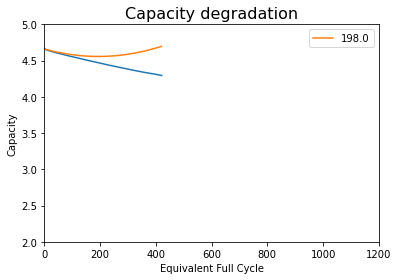

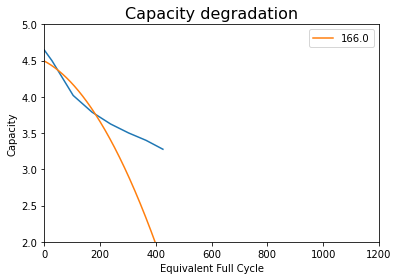

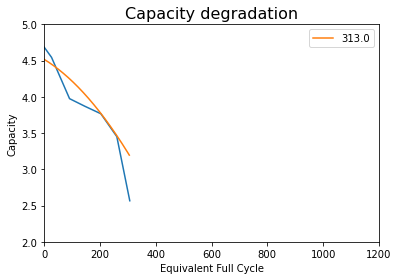

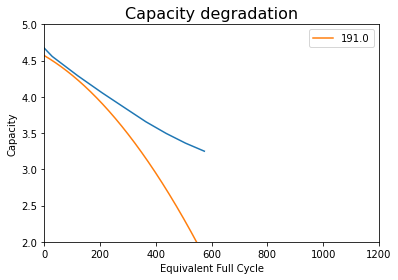

In [107]:
for key in test_key:
    inputk = np.array([key])
    plt.figure(key)
    plot_empirical_selected(inputk,l,d)
    plot_curve_pred(y_with_key_test,inputk,l,d)
